In [1]:
import pandas as pd
import numpy as np
import pyjags
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark', {'axes.grid' : False})

In [2]:
# data: https://www.kaggle.com/datasets/prasoonkottarathil/btcinusd?resource=download&select=BTC-Daily.csv
df = pd.read_csv('datasets/BTC-Daily.csv')
print(df.shape)
df.head()

(2651, 9)


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


In [3]:
# sorting values chronologically
df = df.sort_values(by='date')
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
2650,1417132800,2014-11-28 00:00:00,BTC/USD,363.59,381.34,360.57,376.28,3220878.18,8617.15
2649,1417219200,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2746157.05,7245.19
2648,1417305600,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1145566.61,3046.33
2647,1417392000,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2520662.37,6660.56
2646,1417478400,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2593576.46,6832.53


In [7]:
# get asset returns from closing prices
# yt = 100 * (log(Pt) - log(Pt-1)) 
df['asset_return'] = np.log(df['close'].shift(-1) / df['close']) * 100
df['asset_return'] = df['asset_return'].shift(1)
df[['asset_return']]

,asset_return
2650,NaN
2649,0.116866
2648,-0.901267
2647,1.343588
2646,0.227021
...,...
4,2.202837
3,-0.216846
2,-3.731873
1,13.535743


In [8]:
# get asset returns from closing prices, removing the first NaN
asset_returns = df[['asset_return']].to_numpy().flatten()[1:]

In [12]:
# sampling configs
CHAINS=2
ITERS=20000

# JAGS sampling
jags_data = {"y": list(asset_returns), "N": len(asset_returns)}
parameters = ['mu', 'phi', 'sigma']
jags_model_string = '''
  model {
    mu ~ dt(0, 10, 1)
    phi ~ dunif(-1, 1)
    sigma ~ dt(0, 5, 1) T(0,)

    h[1] ~ dnorm(0, sigma/sqrt(1 - pow(phi, 2)))
    for (i in 2:N) {
      h[i] ~ dnorm(mu + phi * (h[i-1] - mu), sigma)
    }
    
    for (j in 1:N) {
      y[j] ~ dnorm(0, exp(h[j]/2))
    }
  }
'''
jags_model = pyjags.Model(code=jags_model_string, data=jags_data, chains=CHAINS)
jags_samples = jags_model.sample(iterations=ITERS, vars=parameters)

adapting: iterations 946 of 2000, elapsed 0:00:09, remaining 0:00:10
adapting: iterations 1462 of 2000, elapsed 0:00:14, remaining 0:00:05
adapting: iterations 1966 of 2000, elapsed 0:00:20, remaining 0:00:00
adapting: iterations 2000 of 2000, elapsed 0:00:21, remaining 0:00:00
sampling: iterations 790 of 40000, elapsed 0:00:08, remaining 0:06:35
sampling: iterations 1286 of 40000, elapsed 0:00:13, remaining 0:06:42
sampling: iterations 1766 of 40000, elapsed 0:00:18, remaining 0:06:40
sampling: iterations 2244 of 40000, elapsed 0:00:24, remaining 0:06:36
sampling: iterations 3210 of 40000, elapsed 0:00:32, remaining 0:06:11
sampling: iterations 3704 of 40000, elapsed 0:00:38, remaining 0:06:09
sampling: iterations 4194 of 40000, elapsed 0:00:43, remaining 0:06:10
sampling: iterations 4676 of 40000, elapsed 0:00:48, remaining 0:06:06
sampling: iterations 5642 of 40000, elapsed 0:00:58, remaining 0:05:51
sampling: iterations 6624 of 40000, elapsed 0:01:08, remaining 0:05:43
sampling: it

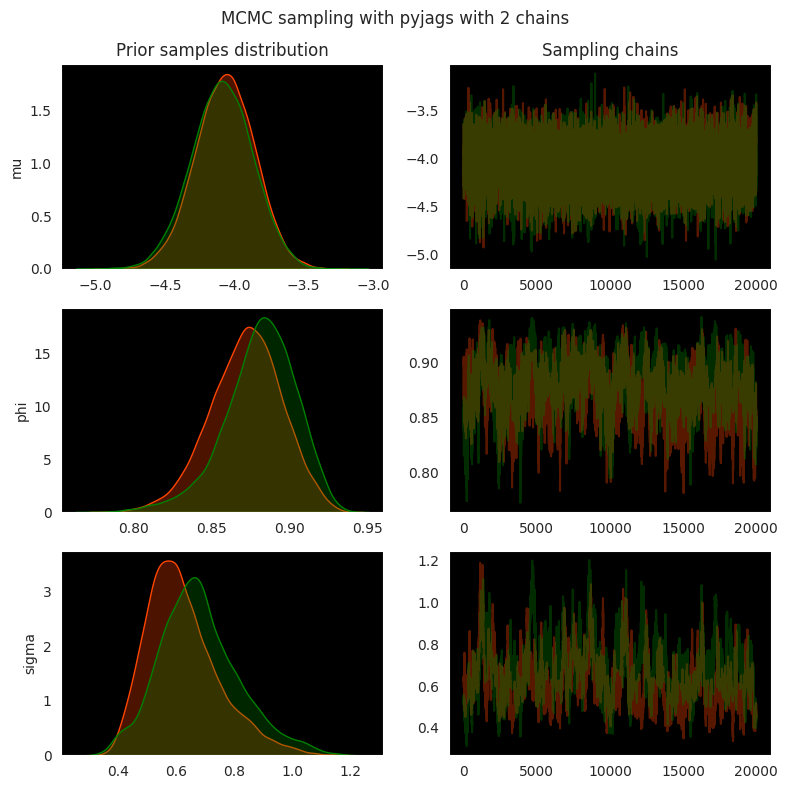

In [13]:
# plots

sample_chains = [jags_samples[p][0] for p in parameters]
colors = ['orangered', 'green']

fig, axs = plt.subplots(len(parameters), 2, figsize=(8, 8))
axs[0, 0].set_title('Prior samples distribution')
axs[0, 1].set_title('Sampling chains')

for p in range(len(parameters)):

  for c in range(CHAINS):
    # prior samples distribution
    sns.kdeplot(data=sample_chains[p][:, c], ax=axs[p, 0], color=colors[c], fill=True, alpha=0.3)
    # sampling steps
    sns.lineplot(data=sample_chains[p][:, c], ax=axs[p, 1], color=colors[c], alpha=0.35)

  axs[p, 0].set_facecolor('black')
  axs[p, 0].set_ylabel(parameters[p])
  axs[p, 1].set_facecolor('black')

fig.suptitle(f'MCMC sampling with pyjags with {CHAINS} chains')
plt.tight_layout()
plt.show()